<span style="color:green">Exploratory Data Analysis for everything related to trains. </span>


In [1]:
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt
import plotly.express as px
from shapely import wkb

## Database connection

In [2]:
DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

# Tester la connexion
try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


In [3]:
result = connection.execute(sqla.text("SELECT reltuples::bigint FROM pg_class WHERE relname='train_data'"))
estimated_count = result.scalar()
print(f"Approximate row count: {estimated_count}")

Approximate row count: 243121024


Rough estimate of the number of rows in the database, was mainly used to check if the connection to the database was sucessful along with the computation time

## EDA about delays

In [4]:
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    COUNT(*) AS row_count, 
    
    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  

FROM train_data
GROUP BY year
ORDER BY year;
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)


,year,row_count,mean_arrival,std_dev_arrival,min_arrival,max_arrival,q1_arrival,median_arrival,q3_arrival,mean_departure,std_dev_depature,min_departure,max_departure,q1_departure,median_departure,q3_departure
0,2014.0,21792638,140.901761,782.195965,-87123.0,520659.0,0.0,42.0,160.0,145.373122,747.446082,-87123.0,520659.0,0.0,43.0,157.0
1,2015.0,21332468,116.212746,422.043395,-88466.0,104450.0,-5.0,28.0,120.0,122.320411,410.787457,-87765.0,73750.0,0.0,31.0,117.0
2,2016.0,21365904,142.676588,983.928616,-87991.0,3960203.0,-3.0,39.0,146.0,146.072588,454.321475,-87930.0,106564.0,0.0,40.0,140.0
3,2017.0,21976359,154.041671,362.448139,-36020.0,22795.0,1.0,54.0,173.0,157.016008,356.437378,-84826.0,36212.0,11.0,56.0,170.0
4,2018.0,22567297,157.051567,357.166114,-23647.0,32518.0,1.0,57.0,183.0,159.650411,350.322972,-43625.0,34464.0,10.0,58.0,180.0
5,2019.0,22351850,127.954879,340.288502,-27108.0,33883.0,-6.0,44.0,148.0,131.496194,334.452595,-27142.0,52980.0,4.0,46.0,146.0
6,2020.0,21123945,88.462508,321.909442,-86716.0,30495.0,-14.0,26.0,101.0,92.615095,313.647096,-86716.0,28380.0,-4.0,29.0,99.0
7,2021.0,22540713,101.203512,311.276038,-86509.0,80615.0,-11.0,30.0,111.0,104.323429,304.556288,-86909.0,80615.0,-2.0,32.0,109.0
8,2022.0,22480415,136.710739,356.314059,-22368.0,33603.0,-6.0,42.0,148.0,147.652881,349.638205,-30465.0,33662.0,11.0,51.0,155.0
9,2023.0,22467606,153.358804,351.680582,-10779.0,23451.0,0.0,54.0,177.0,166.380165,343.931447,-12446.0,21769.0,19.0,65.0,185.0


Overall look at both of the delay variables, we can see that they are relatively the same, so any of the 2 could be used to compute the overall delay of a train. We can also observe some strange values, like the max delay at arrival in 2016 being 1000 hours and all the values for the min delay being also really high. looking at the range between at the first and 3rd quartile, most of the train have a reasonable delay of maximum 3 minutes. The number of travels between the years never changes by more than 10% but we can still see an increase over the years.

In [4]:
# SQL query to get statistics for both columns per month & year
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    EXTRACT(MONTH FROM departure_date) AS month, 
    COUNT(*) AS row_count, 

    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  
FROM train_data
GROUP BY year, month
ORDER BY year, month;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)

       year  month  row_count  mean_arrival  std_dev_arrival  min_arrival  \
0    2014.0    1.0    1900458    119.170084       399.625213     -36003.0   
1    2014.0    2.0    1734004    118.748212       630.960472     -86595.0   
2    2014.0    3.0    1868053    129.796352       472.707383     -83157.0   
3    2014.0    4.0    1824809    113.133004       433.310321     -86349.0   
4    2014.0    5.0    1839737    131.639121       369.524129     -85531.0   
..      ...    ...        ...           ...              ...          ...   
127  2024.0    8.0    1862513    122.777168       357.951857      -3466.0   
128  2024.0    9.0    1935800    146.573065       314.830648      -3636.0   
129  2024.0   10.0    2031774    139.467159       309.503791      -2740.0   
130  2024.0   11.0    1861370    161.628514       512.827980    -170383.0   
131  2024.0   12.0    1983701    114.129460       305.975623     -82489.0   

     max_arrival  q1_arrival  median_arrival  q3_arrival  mean_departure  \

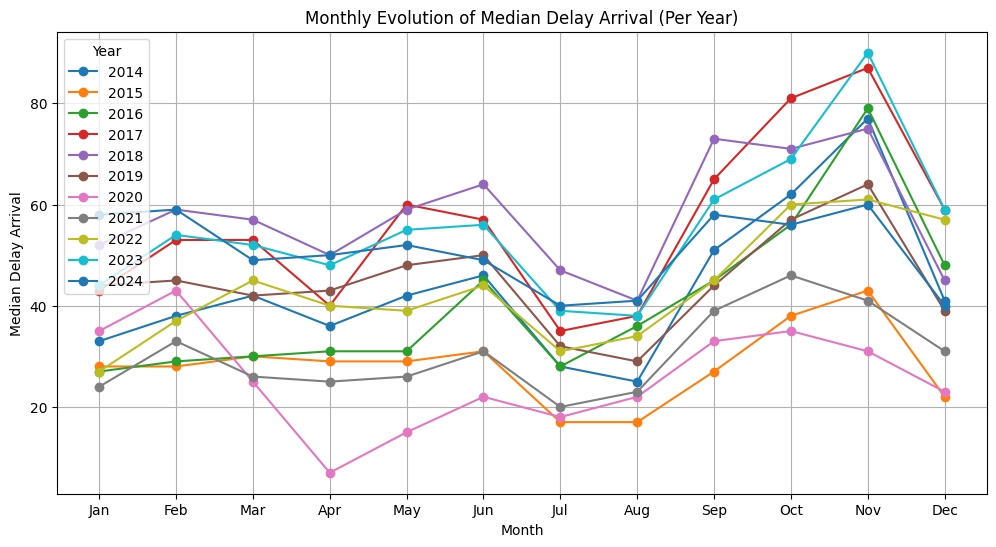

In [5]:
#Milestone2 Median

df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)

df["month"] = df["month"].astype(int)
df = df.sort_values(["year", "month"])

plt.figure(figsize=(12, 6))

for year, group in df.groupby("year"):
    plt.plot(group["month"], group["median_arrival"], marker="o", linestyle="-", label=f"{year}")

plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.xlabel("Month")
plt.ylabel("Median Delay Arrival")
plt.title("Monthly Evolution of Median Delay Arrival (Per Year)")
plt.legend(title="Year")
plt.grid(True)

plt.show()

Most years seem to follow a similar evolution of the delay over the months except for 2020 and 2021, most likely due to covid. We can observe that there is a spike in delay in june and also october and november with nomvember having the highest spike over the years, but there is also a decrease in delays in july and august. All the other months have similar delays.

In [6]:
query = """
SELECT 
TO_CHAR(departure_date, 'MM-DD') AS calendar_day,
AVG((delay_arrival + delay_departure) / 2) AS avg_delay
FROM TRAIN_DATA
GROUP BY calendar_day
ORDER BY avg_delay DESC;"""

df = pd.read_sql(sqla.text(query), connection)



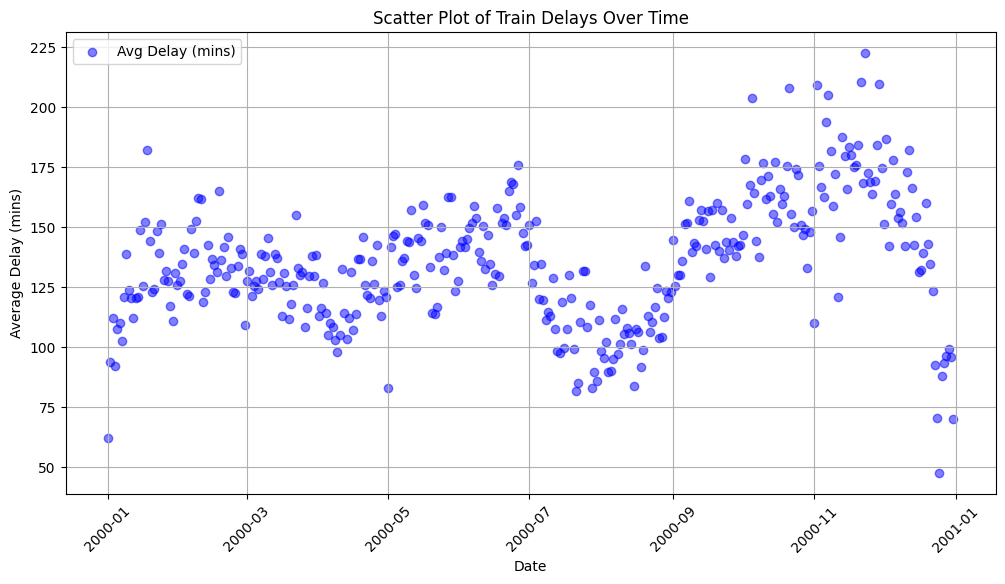

In [7]:
#Fixed year to be able to convert it to datetime
df["calendar_day"] = "2000-" + df["calendar_day"]
df["calendar_day"] = pd.to_datetime(df["calendar_day"])

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df["calendar_day"], df["avg_delay"], color="blue", alpha=0.5, label="Avg Delay (mins)")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average Delay (mins)")
plt.title("Scatter Plot of Train Delays Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels

# Show plot
plt.show()

This plot is very similar to the one comparing the delay per month, we can observe the same spike in june, october and november and a similar decrease in july and august. The average delay per month was not due to having a few days with higher delays but an overal increase in delay all month long.

In [9]:
query = """
SELECT 
    TO_CHAR(departure_date, 'Day') AS weekday,
    EXTRACT(DOW FROM departure_date) AS weekday_number,
    AVG(delay_arrival) AS avg_arrival_delay,
    AVG(delay_departure) AS avg_departure_delay
FROM train_data
GROUP BY weekday, weekday_number
ORDER BY weekday_number;
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,weekday,weekday_number,avg_arrival_delay,avg_departure_delay
0,Sunday,0.0,100.337964,108.013831
1,Monday,1.0,143.720395,148.257006
2,Tuesday,2.0,139.719646,144.336916
3,Wednesday,3.0,133.782585,138.508522
4,Thursday,4.0,138.109238,142.782252
5,Friday,5.0,142.523834,147.261583
6,Saturday,6.0,108.512081,115.779139


We can see that the week-end day are less delay than the week day and the days with the most delay are Monday and Friday.

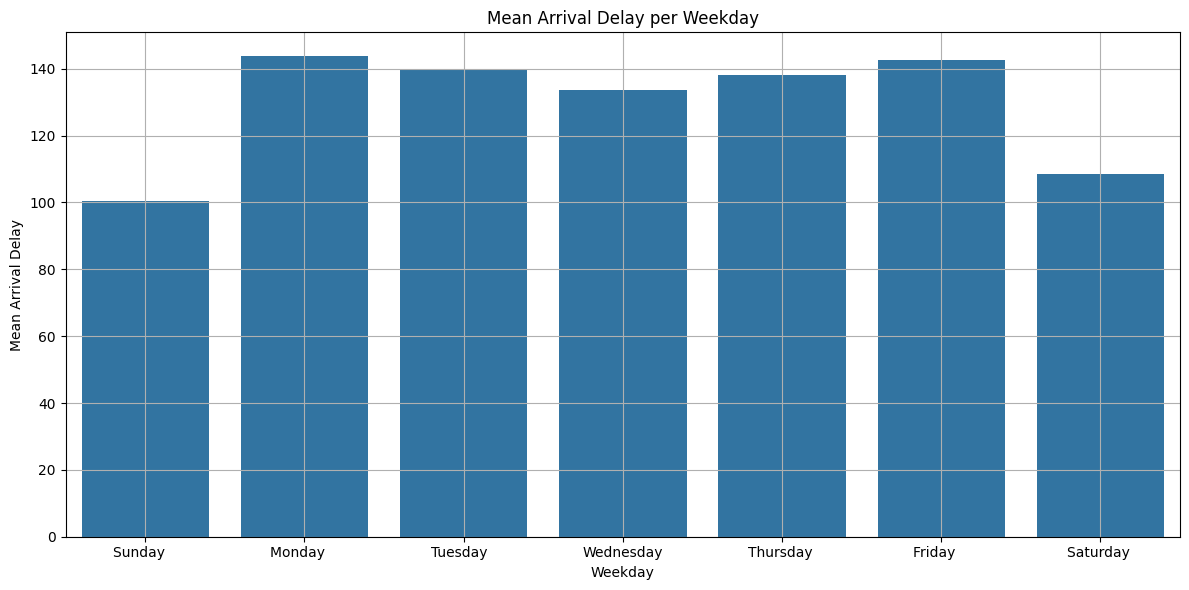

In [10]:
# using sns to plot the data in a bar chart
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.barplot(x="weekday", y="avg_arrival_delay", data=df)
plt.xlabel("Weekday")
plt.ylabel("Mean Arrival Delay")
plt.title("Mean Arrival Delay per Weekday")
plt.grid(True)
plt.tight_layout()
plt.show()


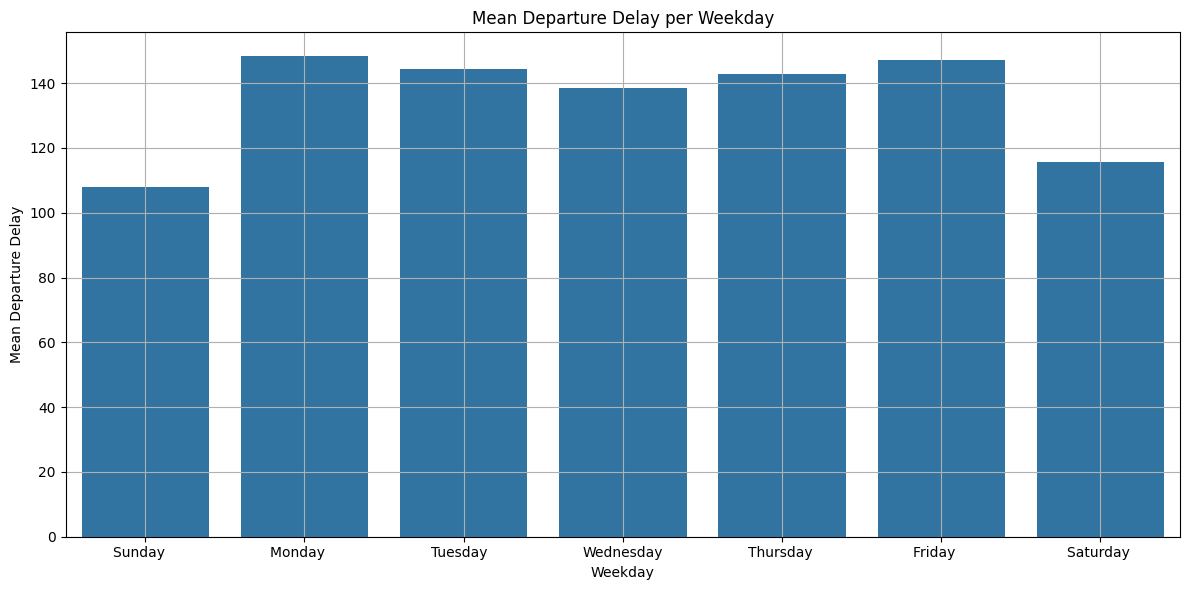

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x="weekday", y="avg_departure_delay", data=df)
plt.xlabel("Weekday")
plt.ylabel("Mean Departure Delay")
plt.title("Mean Departure Delay per Weekday")
plt.grid(True)
plt.tight_layout()
plt.show()

Looking at the delays depending on the days of the week, we can observe that delays are higher during weekdays than during week-ends.

## EDA CONT

In [10]:
# Test 14.9 sec Lei
query = """
    SELECT * from train_data WHERE train_service = 5;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df["relation"].unique())
except Exception as e:
    print(e)
    connection.rollback()

array([58], dtype=int64)

In [ ]:
#Milestone2
query = """
    SELECT 
        RELATION.type, 
        COUNT(TRAIN_DATA.relation) AS relation_count, 
        AVG(TRAIN_DATA.delay_arrival) AS avg_delay_arrival,
        AVG(TRAIN_DATA.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA
    LEFT JOIN RELATION ON TRAIN_DATA.relation = RELATION.id
    GROUP BY RELATION.type
    ORDER BY avg_delay_arrival ASC;
"""

try:
    df = pd.read_sql(sqla.text(query), connection)
except Exception as e:
    print(e)
    connection.rollback()

In [ ]:
#Milestone2
df.dropna(inplace=True)

type_map = {
    0: "Cannot be determined",
    1: "S-trains",
    2: "Rush hour",
    3: "Local",
    4: "InterCity",
    5: "EXTRA",
    6: "International",
    7: "InterCity Tourism"}

df["type"] = df["type"].map(type_map)

display(df)



,type,relation_count,avg_delay_arrival,avg_delay_departure
1,Local,74230626,104.835048,113.459793
2,InterCity Tourism,461456,106.815073,110.580880
3,S-trains,10871598,129.661751,131.077843
4,InterCity,137749894,135.710369,140.071188
5,Rush hour,12834054,151.239065,152.185058
6,EXTRA,2554425,323.626289,324.843277
7,International,4079685,356.166931,355.340762
8,Cannot be determined,332183,392.406269,379.588831


In [ ]:
#Milestone2
query = """
    SELECT 
        RELATION.type, 
        COUNT(TRAIN_DATA.relation) AS total_trains,
        COUNT(CASE WHEN TRAIN_DATA.delay_arrival > 300 THEN 1 END) AS late_trains,
        ROUND(
            (COUNT(CASE WHEN TRAIN_DATA.delay_arrival > 300 THEN 1 END) * 100.0) / NULLIF(COUNT(TRAIN_DATA.relation), 0), 2
        ) AS late_percentage
    FROM TRAIN_DATA
    LEFT JOIN RELATION ON TRAIN_DATA.relation = RELATION.id
    GROUP BY RELATION.type
    ORDER BY late_percentage ASC;
"""

try:
    df = pd.read_sql(sqla.text(query), connection)
    df.dropna(inplace=True)
    df["type"] = df["type"].map(type_map)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()


,type,total_trains,late_trains,late_percentage
0,Local,74230626,6620085,8.92
1,InterCity Tourism,461456,45946,9.96
2,S-trains,10871598,1204330,11.08
3,InterCity,137749894,17807203,12.93
4,Rush hour,12834054,1873943,14.60
5,EXTRA,2554425,438382,17.16
6,Cannot be determined,332183,82782,24.92
7,International,4079685,1059185,25.96


The relations with higher delays are either the extra travels, or travels towards other countries. The lowest delays are for local and IC travels, which are more frequent and would require lower delays.

There are 216 different relation in the dataset, the most common are the Intercity trains followed by those in rush hours (P). The least common ones are internationals trains and some local ones. 

In [18]:
query = """
    SELECT STATIONS.name, COUNT(train_data.ptcar_name) AS STATION_count
    FROM train_data
    LEFT JOIN STATIONS ON train_data.ptcar_name = STATIONS.id
    GROUP BY STATIONS.name
    ORDER BY STATION_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,name,station_count
0,FELUY-ZONING,1
1,EIJSDEN,1
2,CLABECQ-MARCHANDISES,1
3,TROISVIERGES,1
4,ROTTERDAM CENTRAAL,1
...,...,...
786,BRUSSEL-CONGRES,3897367
787,BRUSSEL-KAPELLEKERK,3897420
788,BRUSSEL-CENTRAAL,3897471
789,BRUSSEL-NOORD,3915972


There are a few stations that have been rarely used, but the ones seeing the most traffics are all the stations within the capital city. The stations used only one time may have been due to some exceptional circumstances such as accident on the tracks, or may be due to a train that had only one travel

In [19]:
query = """
    SELECT train_data.ptcar_name, STATIONS.name, COUNT(train_data.ptcar_name) AS STATION_count 
    FROM train_data
    LEFT JOIN STATIONS ON train_data.ptcar_name = STATIONS.id
    GROUP BY train_data.ptcar_name, STATIONS.name
    HAVING COUNT(train_data.ptcar_name) < 10
    ORDER BY STATION_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,ptcar_name,name,station_count
0,188,CLABECQ,1
1,189,CLABECQ-MARCHANDISES,1
2,226,EIJSDEN,1
3,637,ROTTERDAM CENTRAAL,1
4,759,VOROUX-BASE TRAVAUX LGV,1
5,30,ANTWERPEN-D.S.-IJSLAND,1
6,31,ANTWERPEN-D.S.-LILLO,1
7,535,MONCEAU-CHARGEMENT GASOIL,1
8,33,ANTWERPEN-D.S.-PETROL,1
9,34,ANTWERPEN-D.S.-WILMARSDONK,1


We selected only the stations which had less than 10 stops. There are 400 of them and most of them are from Antwerpen.

In [20]:
toCheck = df["ptcar_name"].astype(int).tolist()
print(toCheck)
query = sqla.text("SELECT * FROM train_data WHERE ptcar_name IN :values")
df_result = pd.read_sql(query, connection, params={"values": tuple(toCheck)})

[188, 189, 226, 637, 759, 30, 31, 535, 33, 34, 467, 446, 295, 24, 254, 733, 285, 29, 63, 297, 487, 543, 702, 32, 62, 51, 336, 288, 36, 60, 807, 296, 27, 26, 293, 25, 806, 802, 46, 790]


In [21]:
print(df_result)

    departure_date  train_number  relation  train_service  ptcar_number  \
0       2014-03-26         17937         2              7          1505   
1       2014-01-16         17914         2              7           861   
2       2014-01-16         17916         2              7           861   
3       2014-03-03         17906         2              7          1505   
4       2014-04-08         17907         2              7          1505   
..             ...           ...       ...            ...           ...   
119     2024-10-05           784       165              7          1888   
120     2024-10-05           783       165              7          1888   
121     2024-10-05           782       165              7          1888   
122     2024-11-05         14402         0              7          1722   
123     2024-11-05         14403         0              7          1722   

    line_number_departure real_time_arrival real_time_departure  \
0                   27L/5       

Looking at the full rows for the stations with very few travels, we found out that most of them are from extra services. Other values are from local trains which are already fewer inside the dataset so them having very little stops could be explained by that.

In [3]:
#Milestone 2 

query = """
SELECT 
    r.name AS region_name,
    AVG(td.delay_arrival) AS avg_delay_arrival,
    AVG(td.delay_departure) AS avg_delay_departure
FROM TRAIN_DATA td
JOIN STATIONS s ON td.ptcar_name = s.id
JOIN REGION r ON s.region = r.id
GROUP BY r.name
ORDER BY r.name;
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,region_name,avg_delay_arrival,avg_delay_departure
0,Foreign Country,1242.666667,1242.666667
1,RÃ©gion de Bruxelles-Capitale - Brussels Hoofd...,152.907143,154.664179
2,Vlaanderen,120.160768,125.219564
3,Wallonie,141.192669,148.136184


In [4]:
#Milestone 2
query = """
SELECT 
    r.name AS region_name,
    AVG(td.delay_arrival) AS avg_delay_arrival,
    AVG(td.delay_departure) AS avg_delay_departure
FROM TRAIN_DATA td
JOIN STATIONS s ON td.station_arrival= s.id
JOIN REGION r ON s.region = r.id
GROUP BY r.name
ORDER BY r.name;
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,region_name,avg_delay_arrival,avg_delay_departure
0,Foreign Country,207.515489,211.564195
1,RÃ©gion de Bruxelles-Capitale - Brussels Hoofd...,162.537405,164.903043
2,Unknown region,152.905321,156.103478
3,Vlaanderen,113.726494,119.067773
4,Wallonie,132.528601,138.746422


In [9]:
#Milestone 2

QUERY = """
WITH DelayedCounts AS (
    SELECT
        ptcar_name AS station_id,
        COUNT(*) AS total_count,
        SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
        (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
    FROM TRAIN_DATA
    GROUP BY ptcar_name
    HAVING COUNT(*) >= 100
)
SELECT 
    s.id, 
    s.name, 
    dc.total_count, 
    dc.delayed_count, 
    dc.delay_percentage
FROM DelayedCounts dc
JOIN STATIONS s ON dc.station_id = s.id
ORDER BY dc.delay_percentage DESC;
"""

df = pd.read_sql(sqla.text(QUERY), connection)

display(df)

total = df["total_count"].sum()
delayed = df["delayed_count"].sum()
delay_percentage = (delayed / total) * 100

print(f"Total number of trains: {total}")
print(f"Total number of delayed trains: {delayed}")
print(f"Percentage of delayed trains: {delay_percentage:.2f}%")

,id,name,total_count,delayed_count,delay_percentage
0,764,VORST-RIJTUIGEN-DIENSTPERRON,848,591,69.693396
1,337,HASSELT-L.C.I.,371,244,65.768194
2,585,OOSTENDE-BUNDEL B,167,108,64.670659
3,537,MONCEAU-RECEPTION,104,62,59.615385
4,767,VORST-ZUID-SPOREN 920/926,1487,723,48.621385
...,...,...,...,...,...
713,635,RONSE,131960,3791,2.872840
714,701,SPA-GERONSTERE,119413,3249,2.720809
715,800,ZEEBRUGGE-DORP,72246,1940,2.685270
716,814,Zwankendamme,30974,696,2.247046


Total number of trains: 243112665
Total number of delayed trains: 29131279
Percentage of delayed trains: 11.98%


In [19]:
QUERY = """
SELECT 
    s_dep.name AS departure_station,
    s_arr.name AS arrival_station,
    COUNT(CASE WHEN t.delay_arrival > 300 THEN 1 END) * 100.0 / COUNT(*) AS percentage_delayed
FROM TRAIN_DATA t
JOIN STATIONS s_dep ON t.station_departure = s_dep.id
JOIN STATIONS s_arr ON t.station_arrival = s_arr.id
GROUP BY s_dep.name, s_arr.name
ORDER BY percentage_delayed DESC;
"""

df = pd.read_sql(sqla.text(QUERY), connection)

display(df)

test = df[df['departure_station'] == 'LIEGE-SAINT-LAMBERT']

print(test)


,departure_station,arrival_station,percentage_delayed
0,BERLIN HBF,BRUSSEL-ZUID,97.072254
1,WIEN HBF,BRUSSEL-ZUID,75.277966
2,BRUSSEL-ZUID,GERAARDSBERGEN,56.696125
3,PRAHA HL.N.,BRUSSEL-ZUID,56.093906
4,ESSEN-GRENS,OOSTENDE,51.270208
...,...,...,...
444,NAMUR,WAVRE,0.980975
445,WAVRE,NAMUR,0.968816
446,ARLON,LUXEMBOURG,0.612848
447,ATHUS,LUXEMBOURG,0.120742


       departure_station   arrival_station  percentage_delayed
122  LIEGE-SAINT-LAMBERT      BRUSSEL-ZUID           13.709894
131  LIEGE-SAINT-LAMBERT              MONS           13.297817
148  LIEGE-SAINT-LAMBERT  VERVIERS-CENTRAL           12.181423
211  LIEGE-SAINT-LAMBERT        Aachen Hbf            9.586276


In [ ]:
query = """
SELECT 
    ptcar_name, 
    AVG(COALESCE(delay_departure, 0) - COALESCE(delay_arrival, 0)) AS avg_station_delay
    COUNT(*)
FROM TRAIN_DATA
GROUP BY ptcar_name
HAVING COUNT(*) >= 100  -- Ensure the ptcar_name appears at least 100 times
ORDER BY avg_station_delay DESC
LIMIT 20;"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,ptcar_name,avg_station_delay
0,706,738.033109
1,669,172.755772
2,523,156.220404
3,48,109.833663
4,668,106.526316
5,541,84.132450
6,50,82.421111
7,650,81.321839
8,145,73.308458
9,443,66.472071


Having a look at the delay that is accumulated at a current stop, only considering stations appearing at least 100 times to not have high values for a single travel. The highest average delay is really big, a train will on average be late by an additional 12 minutes by going through this station. The others 19 highest average delay on a station are more reasonable, with a maximum of only an additional 3 minutes of delay but most of them having around 1 minute.

In [3]:
query = """
SELECT 
    S.name AS station_name, 
    AVG(COALESCE(TD.delay_departure, 0) - COALESCE(TD.delay_arrival, 0)) AS avg_station_delay,
    COUNT(*) AS station_count
FROM TRAIN_DATA TD
JOIN STATIONS S ON TD.ptcar_name = S.id  -- Join with STATIONS to get the real name
GROUP BY S.name
HAVING COUNT(*) >= 100  -- Ensure the station appears at least 100 times
ORDER BY avg_station_delay DESC
LIMIT 20;
"""

df = pd.read_sql(sqla.text(query), connection)
display(df)

,station_name,avg_station_delay,station_count
0,STOCKEM-FAISCEAU A,738.033109,1782
1,SCHAARBEEK-WASINSTALLATIE,172.755772,823
2,MERELBEKE-SAS T.W.,156.220404,7028
3,ANTWERPEN-NOORD-BUNDEL C2,109.833663,1010
4,SCHAARBEEK-VORMING,106.526316,741
5,MONTZEN,84.132450,151
6,ANTWERPEN-NOORD-BUNDEL N,82.421111,900
7,SCHAARBEEK-BUNDEL V,81.321839,6090
8,BRUGGE-BUNDEL B,73.308458,201
9,LEOPOLDSBURG,66.472071,117065


In [24]:
query = """
    SELECT SERVICE.name, COUNT(train_data.train_service) AS Train_service_count
    FROM train_data
    LEFT JOIN SERVICE ON train_data.train_service = SERVICE.id
    GROUP BY SERVICE.name
    ORDER BY Train_service_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()


,name,train_service_count
0,CAPTRAIN,3
1,RAILTRAXX,5
2,CROSSRAIL,50
3,BELGORAIL,97
4,EURSLEEPER,12286
5,EUROSTAR,87583
6,EUROSTARFR,159784
7,THI-FACT,2251383
8,SNCB/NMBS,240602732


Out of the 8 services, 4 of them are used extremely rarely. The SNCB/NMBS service is used for around 90% of the travels and the others are rarer but still used frequently

In [25]:
query = """
    SELECT 
        train_service, 
        COUNT(*) AS service_count,
        AVG(delay_departure) AS avg_delay
    FROM TRAIN_DATA
    GROUP BY train_service
    ORDER BY avg_delay DESC;
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,train_service,service_count,avg_delay
0,2,50,3134.360000
1,5,12286,904.273655
2,8,2251383,383.250478
3,4,159784,357.776465
4,1,3,311.000000
5,3,87583,250.270573
6,7,240602732,135.552364
7,6,5,0.000000
8,0,97,-73.443299


Now comparing delays between the train services, we can see that the services which go outside of the country have on average a higher delay, The SNCB/NMBS has an average delay of a bit over 2 minutes which is fairly low. Also, Belgorail, Railtraxx, Captrain and Crossrail are services that are very rarely used, all of them combined don't even make 1% of the travels within the dataset.

In [26]:
query = """
    SELECT 
        (100.0 * SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) / COUNT(*)) AS percentage_greater_than_zero
    FROM train_data;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,percentage_greater_than_zero
0,11.9828


In [9]:
query = """
    SELECT 
        EXTRACT(YEAR FROM departure_date) AS year,
        (100.0 * SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) / COUNT(*)) AS percentage_greater_than_300
    FROM train_data
    GROUP BY year
    ORDER BY year;
"""

df = pd.read_sql(sqla.text(query), connection)
display(df)

,year,percentage_greater_than_300
0,2014.0,13.601176
1,2015.0,10.688037
2,2016.0,12.658842
3,2017.0,13.987108
4,2018.0,14.630755
5,2019.0,11.472012
6,2020.0,7.583375
7,2021.0,8.637611
8,2022.0,12.043421
9,2023.0,14.016300


Looking at the infos given by the SNCB, they consider a train to be late from 6 minutes, this makes that 11.98% of the trains in the dataset were running late.

In [27]:
query = """
    SELECT departure_date, 
    AVG(delay_arrival) AS avg_delay_per_train
    FROM TRAIN_DATA
    GROUP BY departure_date
    ORDER BY avg_delay_per_train DESC
    LIMIT 10; 
"""

df = pd.read_sql(sqla.text(query), connection)

display(df)

,departure_date,avg_delay_per_train
0,2014-12-15,2659.030052
1,2023-11-02,1196.010219
2,2016-10-05,580.378941
3,2024-01-18,542.550820
4,2019-07-25,508.139963
5,2022-02-18,492.996752
6,2017-02-18,470.392169
7,2017-11-23,467.244241
8,2020-02-09,457.280170
9,2016-11-21,455.799526


 Looking at the days with the highest average delay, we found some explanations for some of them : 2014-12-15, strike day, 2023-11-02 : storm, 2016-10-05 bomb alert, 2024-01-18 cyber attack, 2020-02-09 repairs on the tracks

In [43]:
q = """
    SELECT 
        EXTRACT(MONTH FROM date) AS month,
        AVG(temperature) AS avg_temperature,
        AVG(dewpoint) AS avg_dewpoint,
        AVG(relative_humidity) AS avg_relative_humidity,
        AVG(precipitation) AS avg_precipitation,
        AVG(snowfall) AS avg_snowfall,
        AVG(wind_direction) AS avg_wind_direction,
        AVG(wind_speed) AS avg_wind_speed,
        AVG(pressure) AS avg_pressure
    FROM WEATHER
    GROUP BY month
    ORDER BY month;
"""

df = pd.read_sql(sqla.text(q), connection)

display(df)

,month,avg_temperature,avg_dewpoint,avg_relative_humidity,avg_precipitation,avg_snowfall,avg_wind_direction,avg_wind_speed,avg_pressure
0,1.0,3.632015,1.678740,87.679770,0.067470,0.001120,204.961205,15.387735,1016.885640
1,2.0,4.920052,1.836313,81.888112,0.053660,0.000736,193.088365,16.393296,1016.406127
2,3.0,6.897321,2.534366,76.083999,0.055095,0.000000,189.803425,14.405849,1015.710480
3,4.0,9.554707,3.973651,70.973407,0.039970,0.000000,183.825973,12.475564,1016.734453
4,5.0,13.314574,7.800434,72.021383,0.050634,0.000000,193.061068,11.738326,1016.657990
5,6.0,17.096297,11.330291,71.498183,0.057314,0.000000,193.745630,11.074657,1016.536488
6,7.0,18.412350,12.446751,71.109433,0.054552,0.000000,216.396549,11.104981,1016.234560
7,8.0,18.227961,12.926480,74.005732,0.049772,0.000000,204.506478,10.749078,1016.001185
8,9.0,15.189119,11.040571,78.368707,0.051178,0.000000,190.890602,10.734455,1017.357113
9,10.0,11.678078,8.986311,84.551963,0.056460,0.000000,189.863386,12.434546,1016.300340


In [44]:
weather_df = df.copy()
weather_df['month'] = weather_df['month'].apply(lambda x: f'Month {x}')

weather_df.set_index('month', inplace=True)


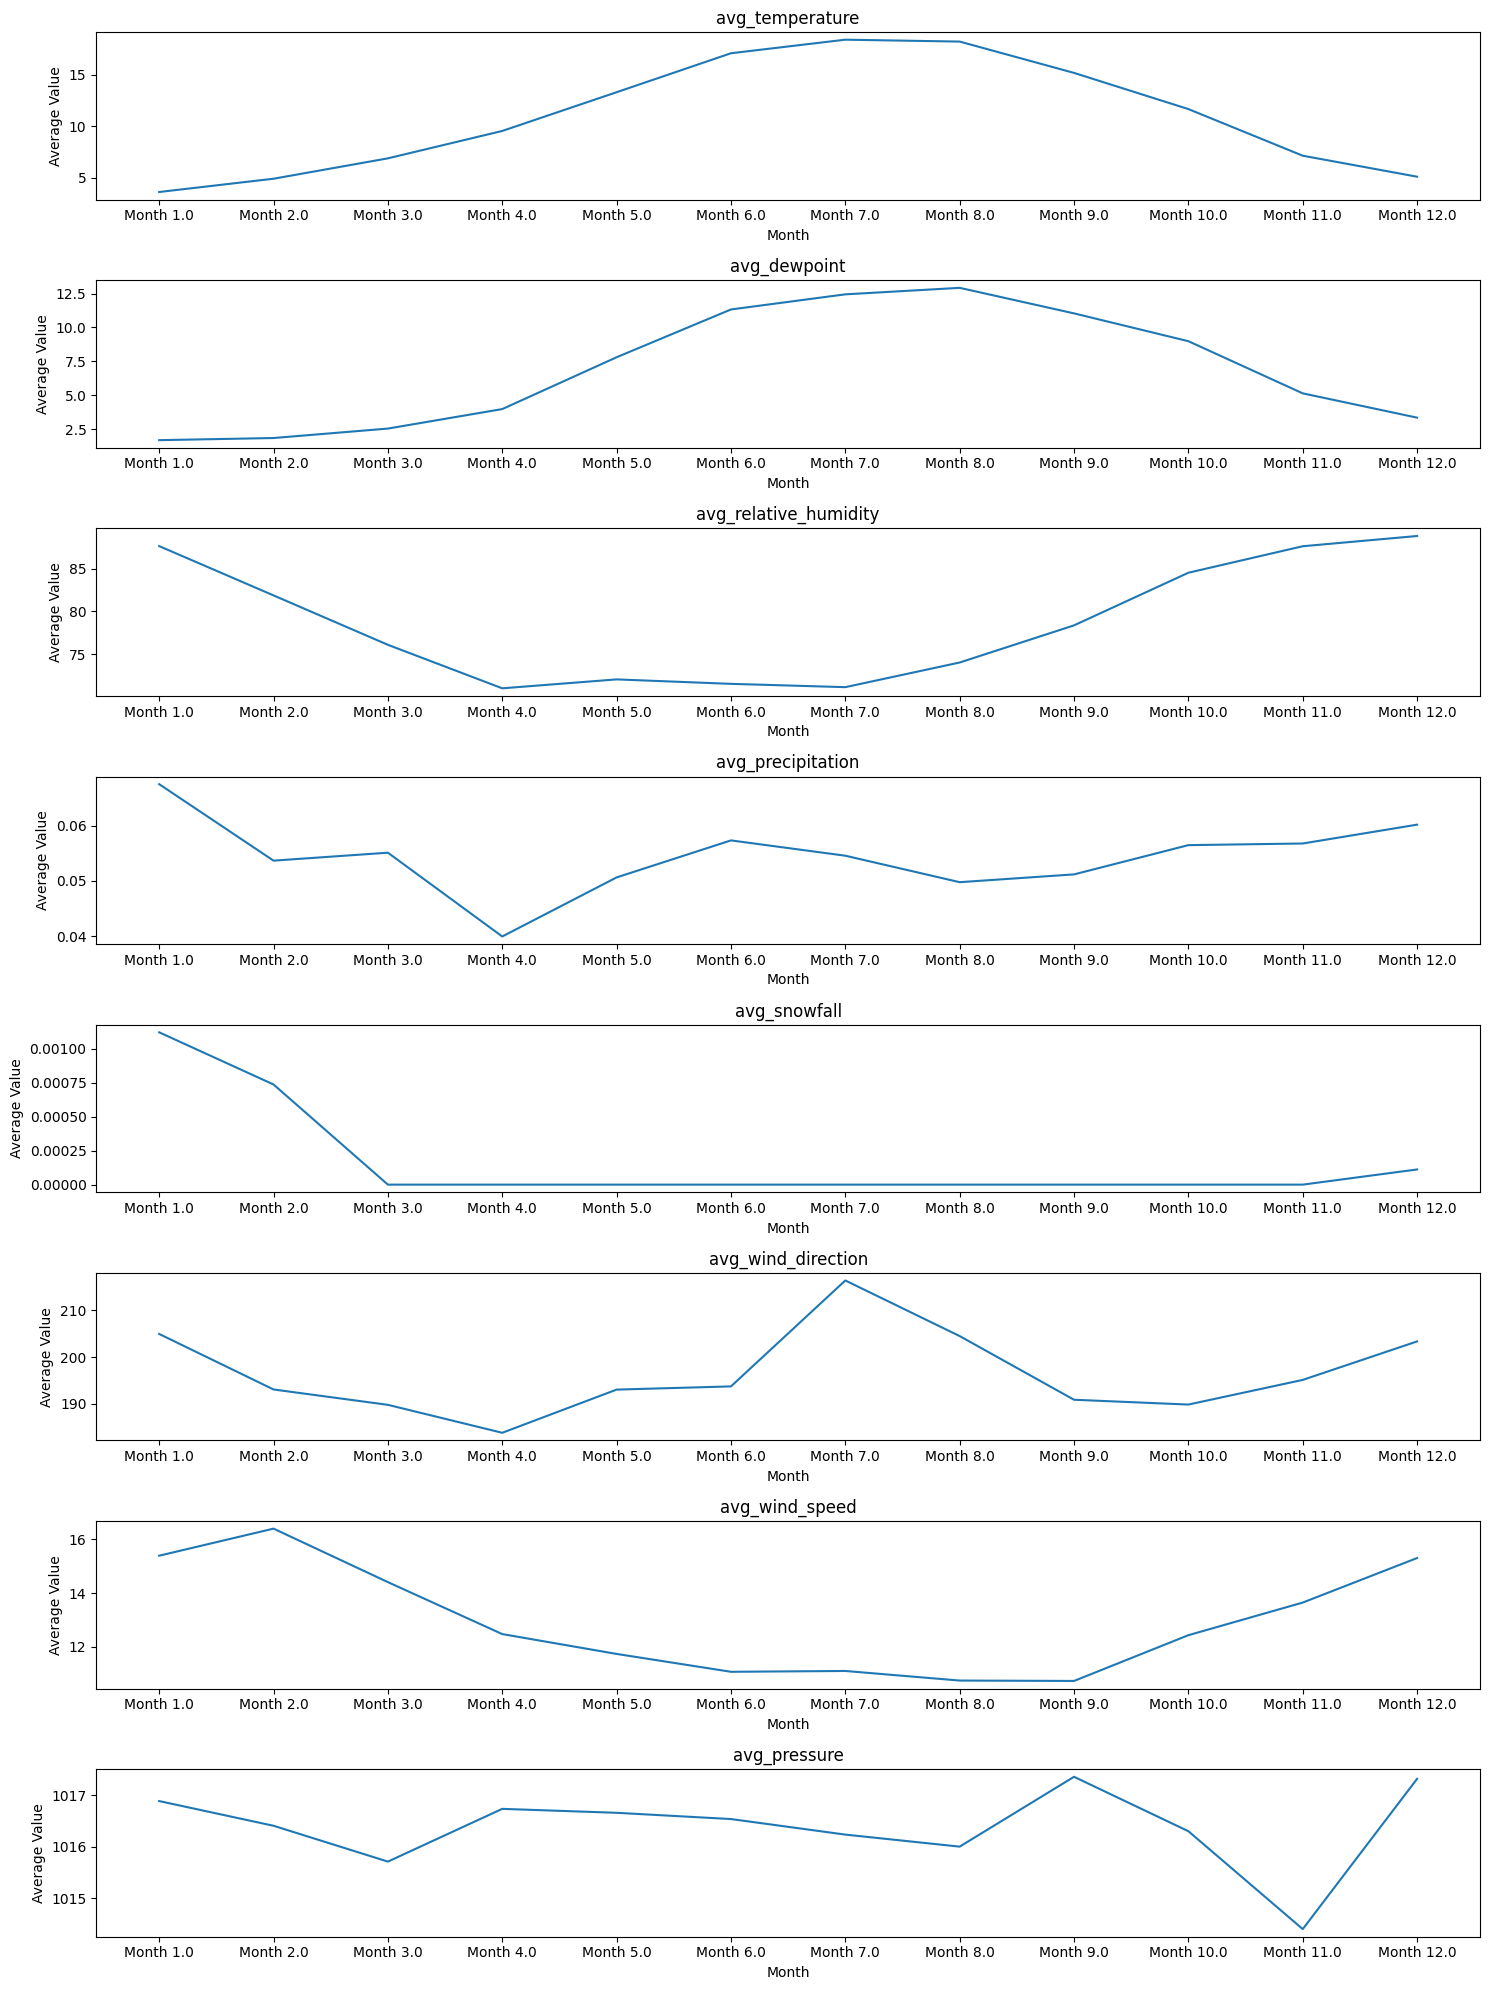

In [45]:
plt.figure(figsize=(15, 20))

for i, column in enumerate(weather_df.columns):
    plt.subplot(len(weather_df.columns), 1, i + 1)
    plt.plot(weather_df.index, weather_df[column], label=column)
    plt.title(column)
    plt.xlabel('Month')
    plt.ylabel('Average Value')

plt.tight_layout()
plt.show()

In [46]:
query = """
    SELECT 
        EXTRACT(MONTH FROM departure_date) AS month,
        AVG(delay_departure) AS avg_train_delay
    FROM TRAIN_DATA
    GROUP BY month
    ORDER BY month;
"""

train = pd.read_sql(sqla.text(query), connection)

display(train)

,month,avg_train_delay
0,1.0,126.974758
1,2.0,138.463517
2,3.0,130.739246
3,4.0,121.655436
4,5.0,139.728102
5,6.0,150.244418
6,7.0,116.889538
7,8.0,109.579014
8,9.0,146.450219
9,10.0,163.226252


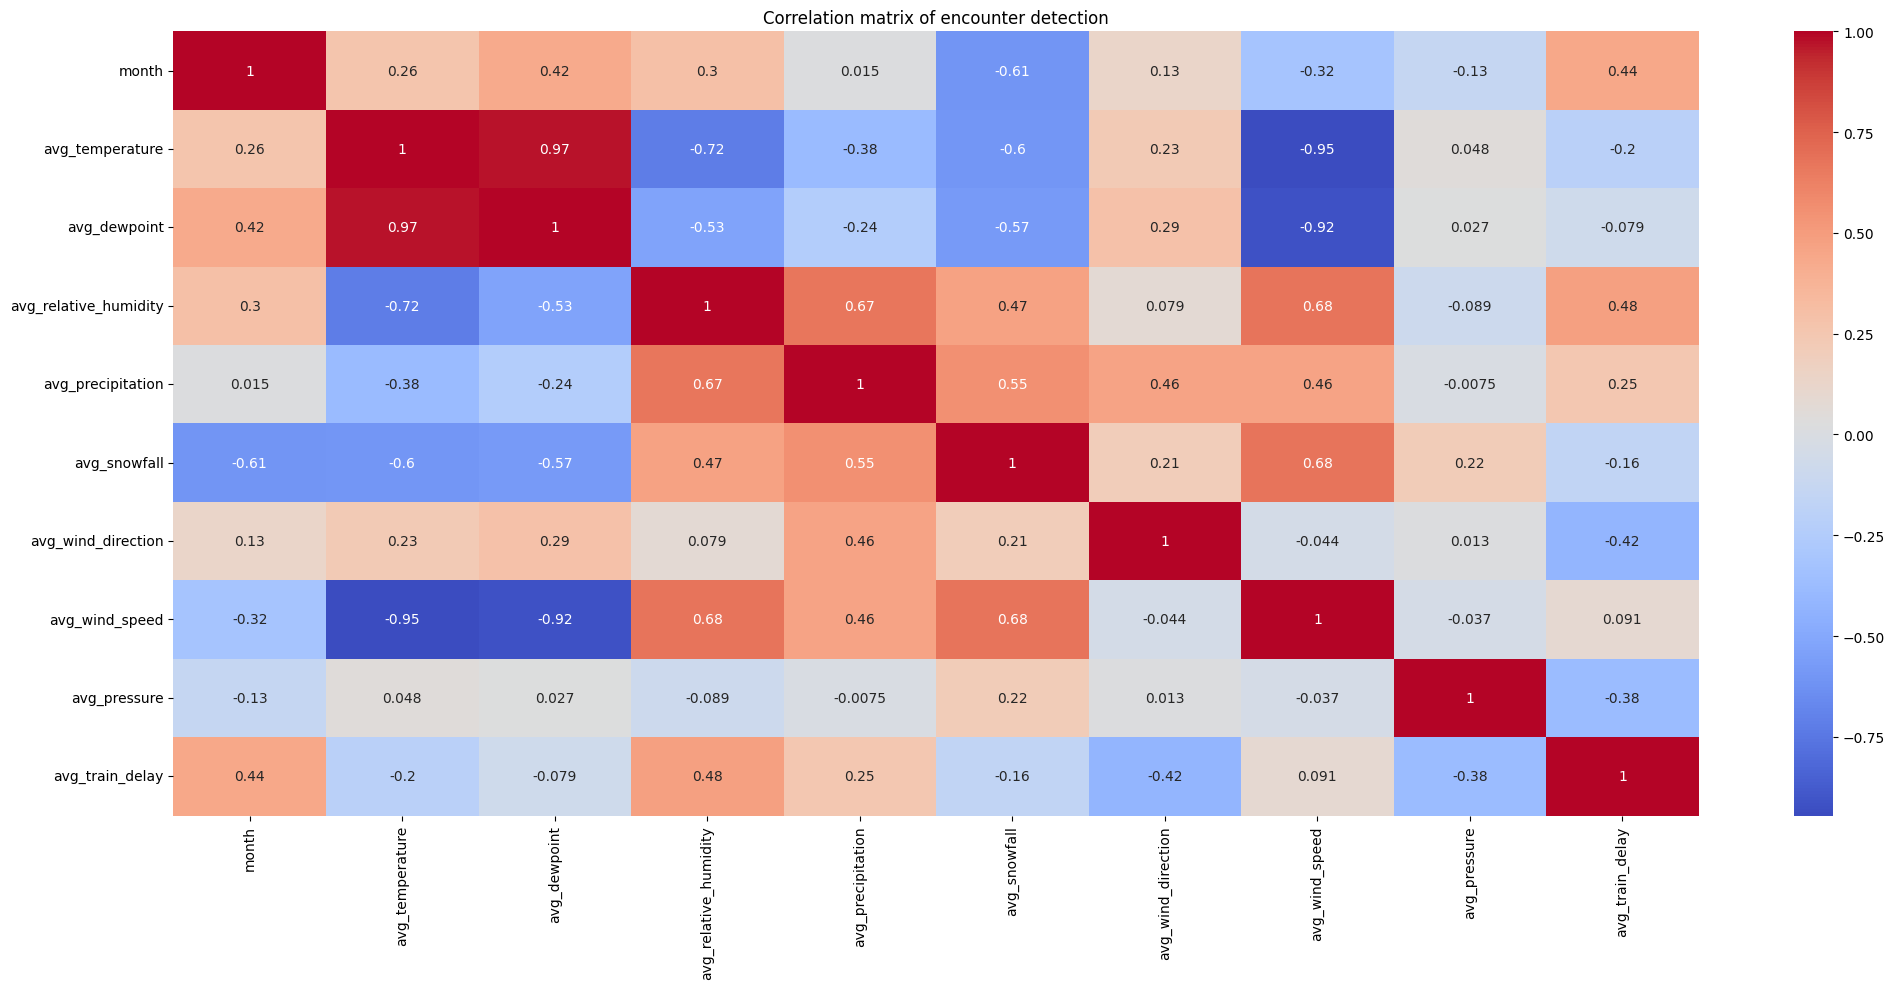

In [47]:
import seaborn as sns
merged = pd.merge(df, train, on='month')
corr = merged.corr()

fig  = plt.figure(figsize=(21, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title('Correlation matrix of encounter detection')
plt.tight_layout()
plt.show()

Looking at the correlation between the average delay and the weather a few variables seem interesting, there are higher correlation with relative humidity, high cloud cover and the radiation. We expected that the correlation of the delays with windgust and precipitation would be higher.

In [ ]:
#Milestone 2 weather update
query = """
WITH Top20PrecipitationDays AS (
    SELECT date
    FROM WEATHER
    GROUP BY date
    ORDER BY SUM(precipitation) DESC
    LIMIT 20
),
DelayStats AS (
    SELECT 
        TD.departure_date, 
        AVG(TD.delay_arrival) AS avg_delay_arrival, 
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY TD.delay_arrival) AS median_delay_arrival,
        AVG(TD.delay_departure) AS avg_delay_departure, 
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY TD.delay_departure) AS median_delay_departure
    FROM TRAIN_DATA TD
    JOIN WEATHER W ON TD.departure_date = W.date
    WHERE W.date IN (SELECT date FROM Top20PrecipitationDays)
    GROUP BY TD.departure_date
)
SELECT * FROM DelayStats;"""

df = pd.read_sql(sqla.text(query), connection)
display(df)

,departure_date,avg_delay_arrival,median_delay_arrival,avg_delay_departure,median_delay_departure
0,2021-01-28,125.880189,37.0,126.817398,38.0
1,2021-06-04,210.796411,49.0,211.662231,49.0
2,2021-07-14,113.408290,24.0,115.951230,26.0
3,2021-07-15,138.840204,28.0,140.585629,29.0
4,2021-10-03,104.782888,37.0,109.915127,39.0
5,2022-02-06,98.935137,27.0,103.604287,30.0
6,2022-09-14,147.664889,55.0,161.439198,67.0
7,2023-01-12,201.391162,81.0,214.112128,93.0
8,2023-03-08,198.895070,81.0,210.325059,93.0
9,2023-03-09,182.224619,77.0,195.052421,89.5


In [ ]:
query = """
WITH Top20PrecipitationDays AS (
    SELECT date
    FROM WEATHER
    GROUP BY date
    ORDER BY AVG(wind_speed) DESC
    LIMIT 20
),
DelayStats AS (
    SELECT 
        TD.departure_date, 
        AVG(TD.delay_arrival) AS avg_delay_arrival, 
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY TD.delay_arrival) AS median_delay_arrival,
        AVG(TD.delay_departure) AS avg_delay_departure, 
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY TD.delay_departure) AS median_delay_departure
    FROM TRAIN_DATA TD
    JOIN WEATHER W ON TD.departure_date = W.date
    WHERE W.date IN (SELECT date FROM Top20PrecipitationDays)
    GROUP BY TD.departure_date
)
SELECT * FROM DelayStats;"""

df = pd.read_sql(sqla.text(query), connection)
display(df)

,departure_date,avg_delay_arrival,median_delay_arrival,avg_delay_departure,median_delay_departure
0,2014-02-15,113.613190,35.0,118.619111,37.0
1,2015-01-15,166.542028,44.0,170.409597,45.0
2,2015-03-31,170.322963,44.0,174.767456,45.0
3,2016-02-08,117.053055,31.0,120.818025,33.0
4,2017-02-23,205.758443,74.0,205.815622,73.0
5,2018-01-03,220.268293,63.0,222.007286,63.0
6,2019-03-04,135.020898,45.0,137.273504,46.0
7,2020-01-14,124.009949,44.0,126.707404,45.0
8,2020-02-09,457.280170,60.0,450.235479,61.0
9,2020-02-10,355.396990,114.0,352.525859,111.0


In [8]:
query = """WITH WindBins AS (
    SELECT 
        FLOOR(wind_direction / 5) * 5 AS wind_bin,  -- Group wind direction into 5-degree ranges
        AVG(TD.delay_arrival) AS avg_delay_arrival, 
        AVG(TD.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA TD
    JOIN WEATHER W ON TD.departure_date = W.date
    GROUP BY wind_bin
    ORDER BY (AVG(TD.delay_arrival) + AVG(TD.delay_departure)) DESC
    LIMIT 5
)
SELECT * FROM WindBins;"""

df = pd.read_sql(sqla.text(query), connection)
display(df)

,wind_bin,avg_delay_arrival,avg_delay_departure
0,75.0,147.447194,152.827565
1,125.0,146.654699,152.696329
2,135.0,145.962269,151.534726
3,85.0,145.714338,151.127185
4,45.0,143.997957,149.699885


In [6]:
connection.rollback()

In [ ]:
#Milestone2
query = """
    SELECT 
        td.holiday AS holiday,
        td.weekend AS weekend,
        AVG(t.delay_arrival) AS mean_delay_arrival,
        AVG(t.delay_departure) AS mean_delay_departure,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_arrival) AS median_delay_arrival,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_departure) AS median_delay_departure
    FROM TRAIN_DATA t
    JOIN type_day td ON t.departure_date = td.date
    GROUP BY td.holiday, td.weekend
    ORDER BY td.holiday, td.weekend;
"""

df = pd.read_sql(sqla.text(query), connection)
type_day_map = {
    0: "Normal Day",
    1: "School Holiday",
    2: "Public Holiday"
}
df["holiday"] = df["holiday"].map(type_day_map)

display(df)

,holiday,weekend,mean_delay_arrival,mean_delay_departure,median_delay_arrival,median_delay_departure
0,Normal Day,False,147.978449,151.106529,49.0,50.0
1,Normal Day,True,112.326090,118.432924,33.0,37.0
2,School Holiday,False,126.225819,133.723297,39.0,44.0
3,School Holiday,True,92.264984,102.116745,26.0,33.0
4,Public Holiday,False,75.457023,84.286194,21.0,28.0
5,Public Holiday,True,85.130366,93.422630,24.0,30.0


On regular days, the average delay is higher than for week-ends or school holidays, then it is even lower for national holidays. This is most likely due to there being fewer trains on holidays lowering the odds of having delay.

In [ ]:
#Milestone2
query = """
    SELECT 
        CASE 
            WHEN EXTRACT(MONTH FROM t.departure_date) IN (12, 1, 2) THEN 'Winter'
            WHEN EXTRACT(MONTH FROM t.departure_date) IN (3, 4, 5) THEN 'Spring'
            WHEN EXTRACT(MONTH FROM t.departure_date) IN (6, 7, 8) THEN 'Summer'
            WHEN EXTRACT(MONTH FROM t.departure_date) IN (9, 10, 11) THEN 'Fall'
        END AS season,
        AVG(t.delay_arrival) AS mean_delay_arrival,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_arrival) AS median_delay_arrival,
        AVG(t.delay_departure) AS mean_delay_departure,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_departure) AS median_delay_departure
    FROM TRAIN_DATA t
    GROUP BY season
    ORDER BY season;
"""

try:
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,season,mean_delay_arrival,median_delay_arrival,mean_delay_departure,median_delay_departure
0,Fall,158.218323,55.0,162.166717,57.0
1,Spring,125.576745,39.0,130.879000,42.0
2,Summer,119.039451,34.0,125.604695,39.0
3,Winter,128.655242,40.0,133.608797,43.0


In [10]:
#Milestone2
query = """
    SELECT 
        EXTRACT(HOUR FROM t.real_time_arrival) AS hour_of_day,
        COUNT(*) AS train_count,
        AVG(t.delay_arrival) AS mean_delay_arrival,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_arrival) AS median_delay_arrival,
        AVG(t.delay_departure) AS mean_delay_departure,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_departure) AS median_delay_departure
    FROM TRAIN_DATA t
    GROUP BY hour_of_day
    ORDER BY hour_of_day;
"""

try:
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,hour_of_day,train_count,mean_delay_arrival,median_delay_arrival,mean_delay_departure,median_delay_departure
0,0.0,1256945,230.110473,46.0,236.222349,48.0
1,1.0,183490,466.130138,140.0,474.466000,137.0
2,2.0,12638,1774.438598,1092.0,1689.748034,880.0
3,3.0,5633,1880.931830,636.0,1748.470007,461.0
4,4.0,768524,47.745551,23.0,57.102538,28.0
5,5.0,4834684,52.356105,22.0,61.072612,27.0
6,6.0,11681542,71.761851,30.0,79.962264,34.0
7,7.0,14902400,113.676898,50.0,121.920460,54.0
8,8.0,14264227,160.047744,66.0,165.401704,68.0
9,9.0,13296124,165.360524,59.0,170.675222,61.0


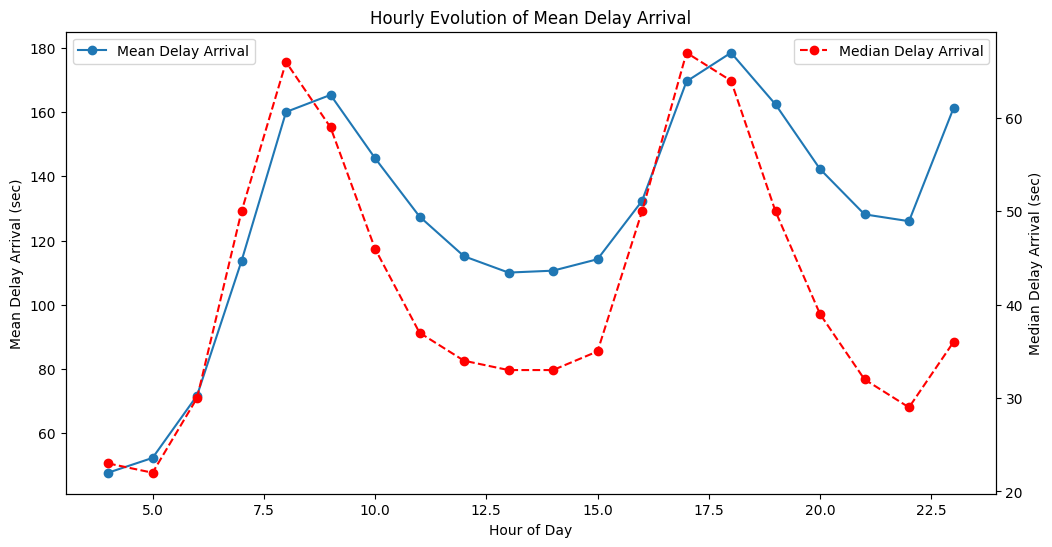

In [11]:
#Milestone2
df.dropna(inplace=True)
df_filtered = df[(df["hour_of_day"] >= 4) & (df["hour_of_day"] <= 23)]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered["hour_of_day"], df_filtered["mean_delay_arrival"], marker="o", linestyle="-", label="Mean Delay Arrival")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Mean Delay Arrival (sec)")
ax2 = ax.twinx()
ax2.plot(df_filtered["hour_of_day"], df_filtered["median_delay_arrival"], marker="o", linestyle="--", color="red", label="Median Delay Arrival")
ax2.set_ylabel("Median Delay Arrival (sec)")
ax.set_title("Hourly Evolution of Mean Delay Arrival")
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [12]:
#Milestone 2
query = """
    SELECT 
        td.holiday AS holiday,
        td.weekend AS weekend,
        EXTRACT(HOUR FROM t.real_time_arrival) AS hour_of_day,
        AVG(t.delay_arrival) AS mean_delay_arrival,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_arrival) AS median_delay_arrival,
        AVG(t.delay_departure) AS mean_delay_departure,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY t.delay_departure) AS median_delay_departure
    FROM TRAIN_DATA t
    JOIN type_day td ON t.departure_date = td.date
    GROUP BY td.holiday, td.weekend, hour_of_day
    ORDER BY td.holiday, td.weekend, hour_of_day;
"""

try:
    df = pd.read_sql(sqla.text(query), connection)
    
    # Mapping holiday codes to readable names
    type_day_map = {
        0: "Normal Day",
        1: "School Holiday",
        2: "Public Holiday"
    }
    df["holiday"] = df["holiday"].map(type_day_map)

    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,holiday,weekend,hour_of_day,mean_delay_arrival,median_delay_arrival,mean_delay_departure,median_delay_departure
0,Normal Day,False,0.0,253.318573,56.0,256.626972,55.0
1,Normal Day,False,1.0,521.429634,188.0,522.611244,183.0
2,Normal Day,False,2.0,1845.205072,1281.0,1720.093411,1017.0
3,Normal Day,False,3.0,1885.930481,361.0,1739.755224,94.0
4,Normal Day,False,4.0,48.953521,24.0,57.763296,28.0
...,...,...,...,...,...,...,...
145,Public Holiday,True,20.0,100.323212,27.0,108.991626,32.0
146,Public Holiday,True,21.0,97.605480,28.0,106.069027,31.0
147,Public Holiday,True,22.0,104.908367,29.0,112.926582,33.0
148,Public Holiday,True,23.0,127.639543,30.0,134.755344,31.0


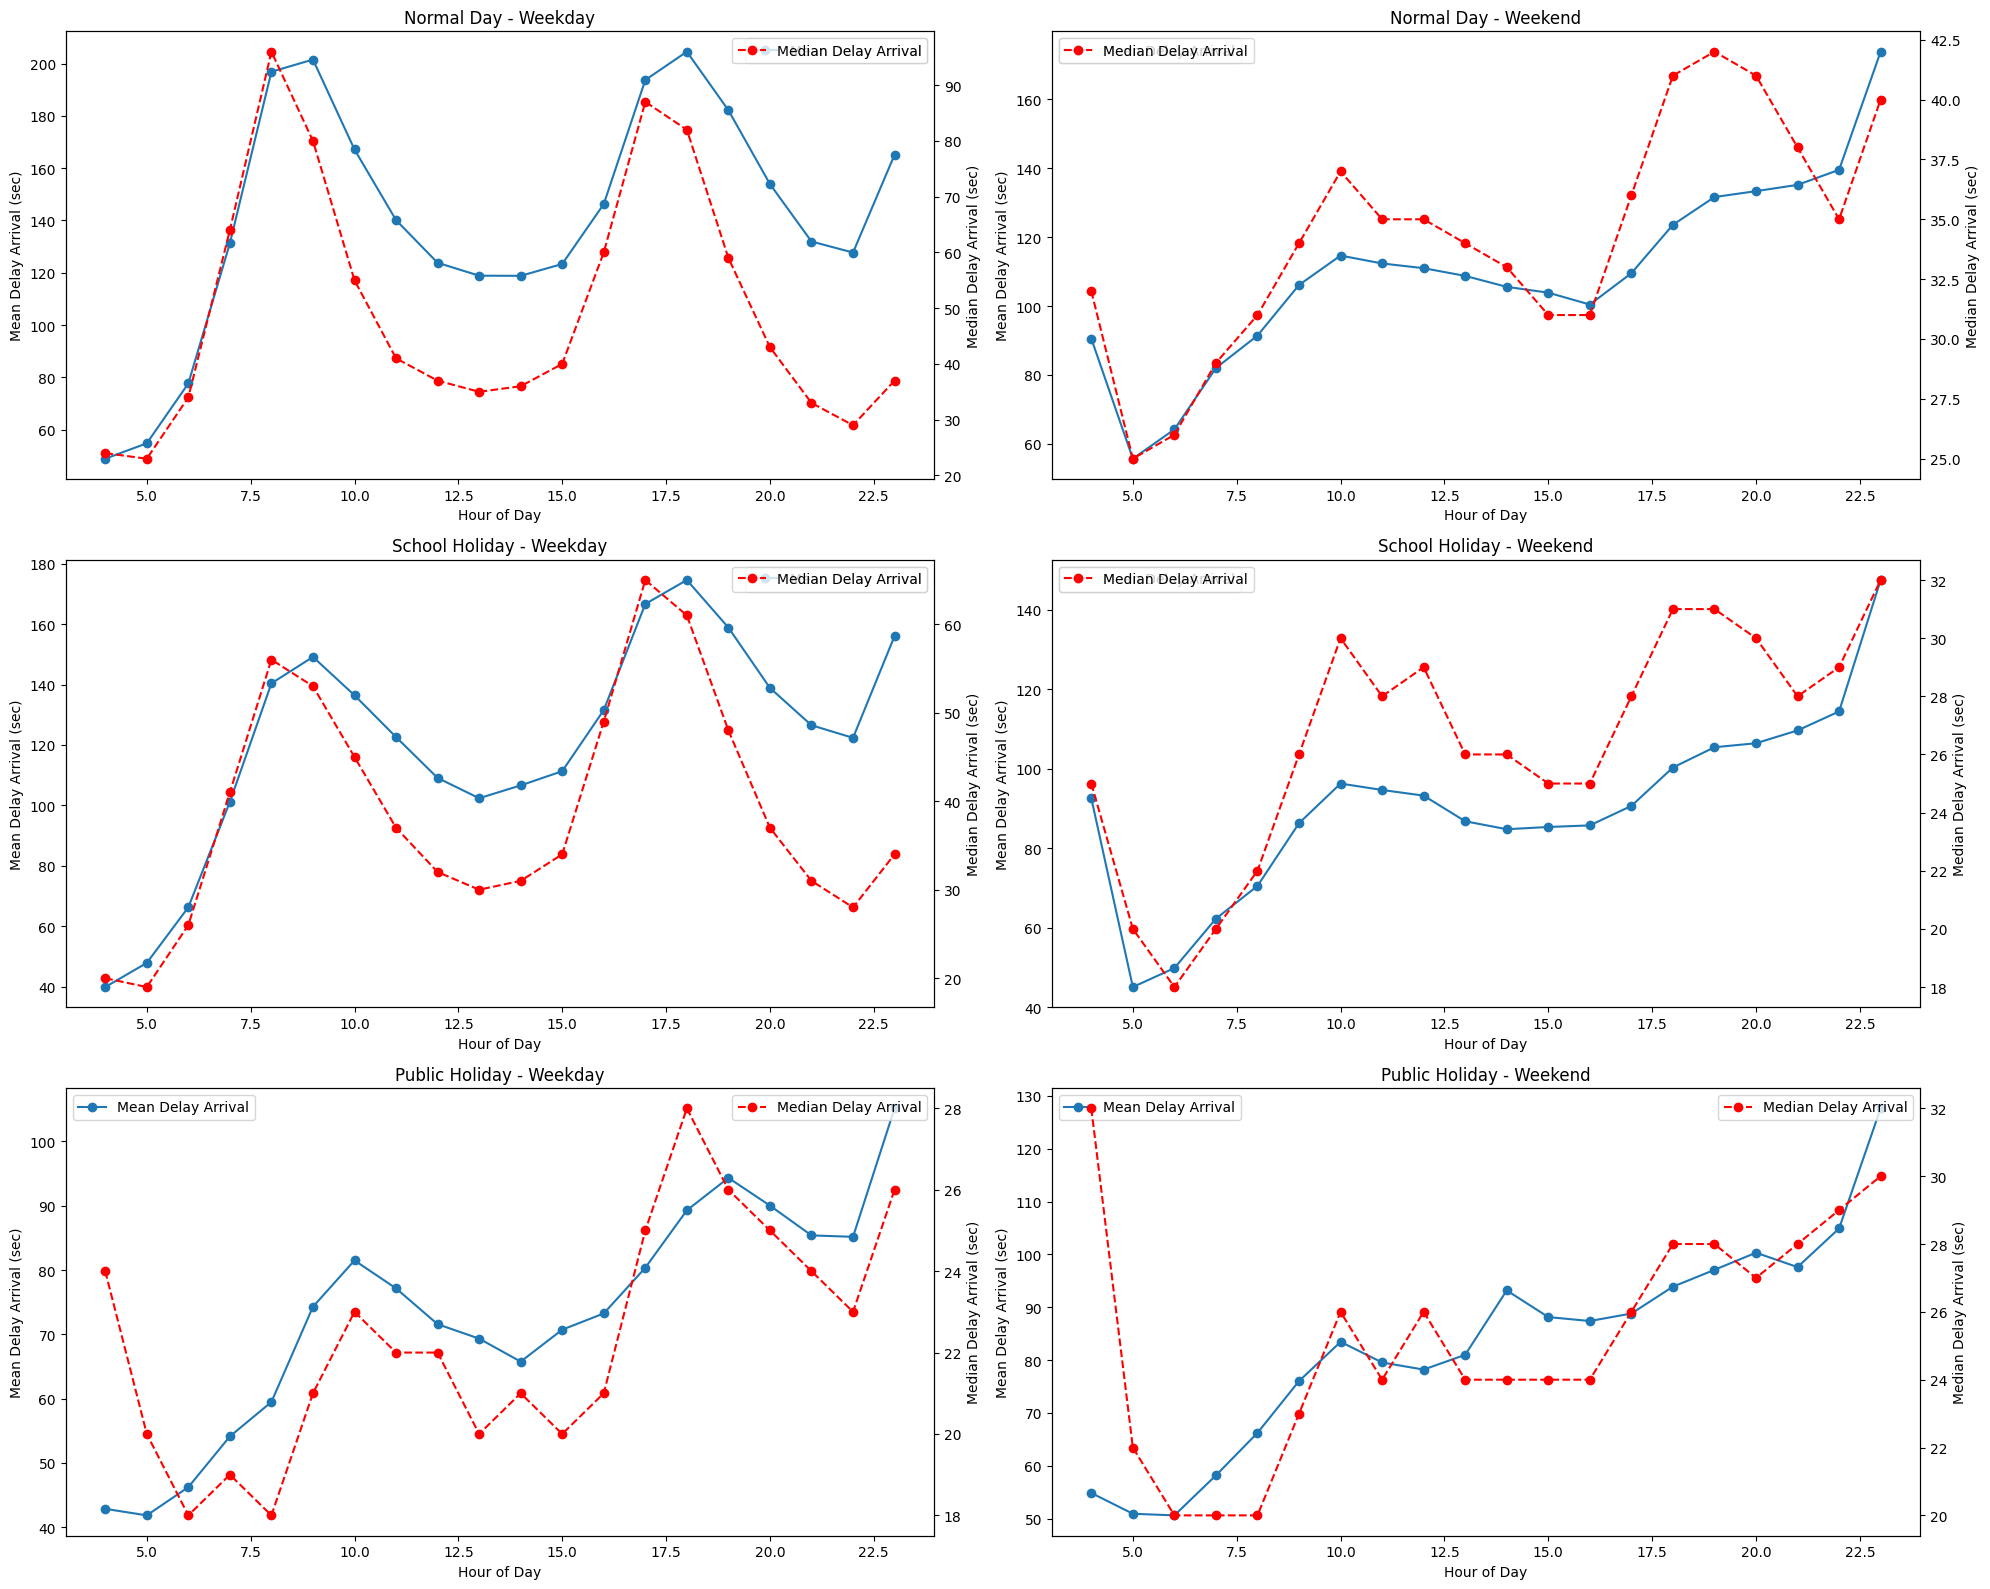

In [13]:
#Milestone2
df.dropna(inplace=True)
df_filtered = df[(df["hour_of_day"] >= 4) & (df["hour_of_day"] <= 23)]

fig, axs = plt.subplots(3,2,figsize=(20, 16))
axs = axs.flatten()

subdf = df_filtered[(df_filtered["holiday"] == "Normal Day") & (df_filtered["weekend"] == 0)]
axs[0].plot(subdf["hour_of_day"], subdf["mean_delay_arrival"], marker="o", linestyle="-", label="Mean Delay Arrival")
axs[0].set_title("Normal Day - Weekday")
axs[0].set_xlabel("Hour of Day")
axs[0].set_ylabel("Mean Delay Arrival (sec)")
axs1 = axs[0].twinx()
axs1.plot(subdf["hour_of_day"], subdf["median_delay_arrival"], marker="o", linestyle="--", color="red", label="Median Delay Arrival")
axs1.set_ylabel("Median Delay Arrival (sec)")
axs[0].legend()
axs1.legend()

subdf = df_filtered[(df_filtered["holiday"] == "Normal Day") & (df_filtered["weekend"] == 1)]
axs[1].plot(subdf["hour_of_day"], subdf["mean_delay_arrival"], marker="o", linestyle="-", label="Mean Delay Arrival")
axs[1].set_title("Normal Day - Weekend")
axs[1].set_xlabel("Hour of Day")
axs[1].set_ylabel("Mean Delay Arrival (sec)")
axs1 = axs[1].twinx()
axs1.plot(subdf["hour_of_day"], subdf["median_delay_arrival"], marker="o", linestyle="--", color="red", label="Median Delay Arrival")
axs1.set_ylabel("Median Delay Arrival (sec)")
axs[1].legend()
axs1.legend()


subdf = df_filtered[(df_filtered["holiday"] == "School Holiday") & (df_filtered["weekend"] == 0)]
axs[2].plot(subdf["hour_of_day"], subdf["mean_delay_arrival"], marker="o", linestyle="-", label="Mean Delay Arrival")
axs[2].set_title("School Holiday - Weekday")
axs[2].set_xlabel("Hour of Day")
axs[2].set_ylabel("Mean Delay Arrival (sec)")
axs1 = axs[2].twinx()
axs1.plot(subdf["hour_of_day"], subdf["median_delay_arrival"], marker="o", linestyle="--", color="red", label="Median Delay Arrival")
axs1.set_ylabel("Median Delay Arrival (sec)")
axs[2].legend()
axs1.legend()


subdf = df_filtered[(df_filtered["holiday"] == "School Holiday") & (df_filtered["weekend"] == 1)]
axs[3].plot(subdf["hour_of_day"], subdf["mean_delay_arrival"], marker="o", linestyle="-", label="Mean Delay Arrival")
axs[3].set_title("School Holiday - Weekend")
axs[3].set_xlabel("Hour of Day")
axs[3].set_ylabel("Mean Delay Arrival (sec)")
axs1 = axs[3].twinx()
axs1.plot(subdf["hour_of_day"], subdf["median_delay_arrival"], marker="o", linestyle="--", color="red", label="Median Delay Arrival")
axs1.set_ylabel("Median Delay Arrival (sec)")
axs[3].legend()
axs1.legend()


subdf = df_filtered[(df_filtered["holiday"] == "Public Holiday") & (df_filtered["weekend"] == 0)]
axs[4].plot(subdf["hour_of_day"], subdf["mean_delay_arrival"], marker="o", linestyle="-", label="Mean Delay Arrival")
axs[4].set_title("Public Holiday - Weekday")
axs[4].set_xlabel("Hour of Day")
axs[4].set_ylabel("Mean Delay Arrival (sec)")
axs1 = axs[4].twinx()
axs1.plot(subdf["hour_of_day"], subdf["median_delay_arrival"], marker="o", linestyle="--", color="red", label="Median Delay Arrival")
axs1.set_ylabel("Median Delay Arrival (sec)")
axs[4].legend()
axs1.legend()


subdf = df_filtered[(df_filtered["holiday"] == "Public Holiday") & (df_filtered["weekend"] == 1)]
axs[5].plot(subdf["hour_of_day"], subdf["mean_delay_arrival"], marker="o", linestyle="-", label="Mean Delay Arrival")
axs[5].set_title("Public Holiday - Weekend")
axs[5].set_xlabel("Hour of Day")
axs[5].set_ylabel("Mean Delay Arrival (sec)")
axs1 = axs[5].twinx()
axs1.plot(subdf["hour_of_day"], subdf["median_delay_arrival"], marker="o", linestyle="--", color="red", label="Median Delay Arrival")
axs1.set_ylabel("Median Delay Arrival (sec)")
axs[5].legend()
axs1.legend()

plt.tight_layout()
plt.show()


## Stations over time

In [ ]:
query = """
    SELECT 
        DATE_PART('year', t.departure_date) AS year,
        DATE_PART('month', t.departure_date) AS month,
        t.station_arrival,
        s.geom,
        s.name
    FROM train_data t
    JOIN stations s ON t.station_departure = s.id
    WHERE t.station_arrival > 0
    GROUP BY year, month, t.station_arrival, s.geom, s.name
    ORDER BY year ASC, month ASC;
"""
df = pd.read_sql(sqla.text(query), connection)

# Convert postgis geom to longitude and latitude
df['geom'] = df['geom'].apply(lambda x: wkb.loads(x) if x else None)
df['latitude'] = df['geom'].apply(lambda point: point.y if point else None)
df['longitude'] = df['geom'].apply(lambda point: point.x if point else None)

# Bounds to have a better view of the europe centered in belgium
custom_bounds = {
    "lataxis": {"range": [42, 55]},
    "lonaxis": {"range": [-5, 15]}  
}

# Process Data
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['time'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)


fig = px.scatter_geo(
    df, lat='latitude', lon='longitude', 
    animation_frame='time', 
    title='Train Station Arrivals Over Time',
    projection='natural earth',
    hover_name='name',
    width=1400,  
    height=800, 
)

fig.update_layout(geo=custom_bounds, 
                  updatemenus=[{"buttons": [{"args": [None, {"frame": {"duration": 100, "redraw": True}, "fromcurrent": True}],  
                                              "method": "animate"}]}])


fig.show()

We can observe that as time goes, the numbers or stations increases. Except between 2020 and 2022 where the number of stations (Especially, for international travels) decrease due to COVID-19.